<h1><center> Playing Atari using Deep Q-Learning </center></h1>

This notebook will introduce Q-Learning, one of the most famous algorithms in Reinforcement Learning which utilizes Neural Networks as function approximators. All tutorials in the Reinforcement Learning sections require prior knowledge of Deep Neural Networks and it is recommended that you have a look at the notebooks in the Deep Learning section.  

We will be implementing Q-Learning using ConvNets to play the game of Pong in Atari 2600 domain. This is a naive replication of David Silver's paper titled [Human-level control through deep reinforcement
learning](https://daiwk.github.io/assets/dqn.pdf). So let's get started!


## 1. Import Dependencies

We will use PyTorch and gym (by OpenAI) for our experiments as these are lightweight and easy to program.

In [1]:
from google.colab import drive
user_name = '/content/drive'
drive.mount(user_name, force_remount=True)

import math, random, os
import gym
import numpy as np
import pickle as pkl
from matplotlib.image import imsave
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import matplotlib.pyplot as plt

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Checkpoint/'

USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else 'cpu')
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from wrappers import make_atari, wrap_deepmind, wrap_pytorch

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 2. Replay Buffer

Almost all Reinforcement Learning methods make use of a Replay Buffer which saves past experiences from a particular episode. Each (state,action,reward,next_state) tuple is stored in the buffer so that the RL algorithm can be trained later when the episode is over.

In [0]:
class ReplayBuffer:
  def __init__(self,capacity): 
    self.capacity = capacity
    self.buffer = []
    self.position = 0

  def push(self, state, action, aux_action, reward, next_state, done):
      state      = np.expand_dims(state, 0)
      next_state = np.expand_dims(next_state, 0)
          
      self.buffer.append((state, action, aux_action, reward, next_state, done))
  
  def sample(self, batch_size):
      state, action, aux_action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
      return np.concatenate(state), action, aux_action, reward, np.concatenate(next_state), done
  
  def __len__(self):
      return len(self.buffer)

## 3. ConvNet Architecture

Now it's time to construct our agent. We will make use of a ConvNet to train our Q-Learning algorithm. Parameters for the ConvNet such as number of layers, filter sizes, stride and activations have all been kept same as the ones mentioned in the paper. Fully-Connected Dense layers consisting of 52 hidden units and ReLU non-linearity have been added on top of the ConvNet architecture.  

Our agent will take the input as the state from the environment, an 84x84 image of the game screen and the output will be one of the following 3 actions- move up (0), move down (1) and do nothing (2). The output layer consists of 3 output nodes of which the $argmax$ is selected as a result of the greedy poliy which we will discuss in the next section. 

In [0]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(self.feature_size(), 1024),
            nn.ReLU(),
            nn.Linear(1024, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        out2 = self.fc2(x)
        return out, out2
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value, aux_q = self.forward(state)
            action  = q_value.max(1)[1].data[0]
            aux_action = aux_q.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
            aux_action = random.randrange(env.action_space.n)
        return action, aux_action

## 4. Update Rule

Now we will make our update rule for the multi-agent algorithm. We will make use of Q-Learning which updates our parameters based on the best/greedy Q-action value $\underset{a}{max}Q(s^{'},a)$. Here, $s^{'}$ is the next state and $a$ is the action selected. The algorithm can be mathematically expressed as followed-  
$Initialize\quad Q(s,a), \forall s \in S, \forall a \in A, \quad Q(term\_state,.) = 0$  
$Repeat(for\quad each\quad episode):$  
$\qquad a,s \leftarrow \pi(s,a)$  
$\qquad execute\quad a$  
$\qquad observe\quad r,s^{'}$  
$\qquad Q(s,a)\leftarrow Q(s,a) + \alpha[r + \gamma\underset{a}{max}Q(s^{'},a) - Q(s,a)]$  
$\qquad s\leftarrow s^{'}$  
$until\; s\; is\; terminal$  

Notice that the update $Q(s,a)\leftarrow Q(s,a) + \alpha[r + \gamma\underset{a}{max}Q(s^{'},a) - Q(s,a)]$ is greedy w.r.t the policy $\pi (s,a)$. Thus, Q-Learning will sample the best action value $\underset{a}{argmax}Q(s,a)$ irrespective of exploration. Hence it is good practice to make the agent explore the environment sufficiently for long-horizon rewards.  

Weight updates for our agents take similar form as the Q-updates-  

<center>$w\leftarrow w + \alpha[r + \gamma\underset{a}{max}Q(s^{'},a,w) - Q(s,a,w)]\nabla Q(s,a,w)$</center>  

For our experiment, we will compute the TD Loss corresponding to each agent as the MSE difference between the Q-value and the expected Q-value ($\underset{a}{max}Q(s^{'},a)$). Mathematically,  

<center>$L = \frac{1}{N}\sum_{i}[Q(s,a) - \underset{a}{max}Q(s^{'},a)]^{2}$</center>  
The total loss will be the weighted sum of the manager and order network losses. Feel free to play around with the weight coefficients and see how loss variation progresses.

In [0]:
def compute_td_loss(batch_size):
    state, action, aux_action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = Variable(torch.LongTensor(action)).to(device)
    aux_action     = Variable(torch.LongTensor(aux_action)).to(device)
    reward     = Variable(torch.FloatTensor(reward)).to(device)
    done       = Variable(torch.FloatTensor(done)).to(device)

    q_values, aux_values      = model(state)
    next_state = torch.cat([state[:,1:,:,:],next_state],1)
    next_q_values, next_aux_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    aux_value          = aux_values.gather(1, aux_action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    next_aux_value     = next_aux_values.max(1)[0]
    intrinsic_reward = abs(aux_value.data - next_aux_value.data)
    internal_rewards.append(intrinsic_reward)
    # intrinsic_reward = torch.clamp(intrinsic_reward,-1,1)
    expected_q_value = reward + intrinsic_reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

## 5. Initialize Setup

Now that we are all ready to train our model, we will initialize our learning setup. We will implement our algorithm on Pong by skipping frequent frames in order to save up on memory and make the process data efficient. We will initialize our environment, our agent, the optimizer and the replay buffer along with its capacity. Keep in mind that Atari environments require significant exploration. Thus, a buffer with large capacity is suitable for the training process. 

In [0]:
#ONLY FOR ATARI
action = 1
def process_atari(state):
    action = 1
    for _ in range(3):
        next_state, reward, done, _ = env.step(action)
        state = np.concatenate((state,next_state),0)
    return state

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

model = CnnDQN((4,84,84), env.action_space.n).to(device)
    
optimizer = optim.RMSprop(model.parameters(), lr=0.00025)

replay_initial = 100
replay_buffer = ReplayBuffer(1000000)

load_model = True
if load_model==True:
    model_checkpoint = torch.load(checkpoint_name+'/model.pth.tar', map_location=device) 
    model.load_state_dict(model_checkpoint['model_state_dict'])
    optimizer.load_state_dict(model_checkpoint['optimizer_state_dict'])
    loss = model_checkpoint['loss']

## 6. Exploration

As discussed in our previous tutorials, we make use of the exploration-starts strategy wherein we start of with 100% exploration and exponentially decay its amount over agent's learning. This is a key step for the model to sample appropriate actions during long-horizon episodic tasks.  

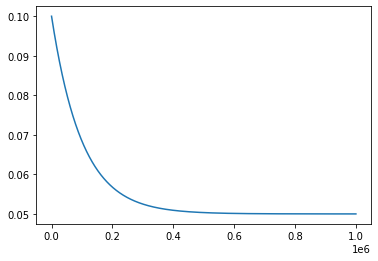

In [0]:
epsilon_start = 0.1
epsilon_final = 0.05
epsilon_decay = 100000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay) 
plt.plot([epsilon_by_frame(i) for i in range(1,1000000)])

## 7. Learning Loop

We initialize our training hyperparameters and reset the environment to its initial state. Now, we make use of the standard PyTorch loop mechanism and step through the environment upon sampling actions from our agent. TD updates are made once the replay buffer reaches a capacity of more than 10,000 experiences. Once the loop completes, we save our progress (loss and rewards) for visualization. 

In [0]:
loss = None
num_frames = 500000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
internal_rewards = []
episode_reward = 0

state = env.reset()
state = process_atari(state)
print(state.shape)
for frame_idx in range(1, num_frames + 1):
    epsilon = 0 #epsilon_by_frame(frame_idx)
    action, aux_action = model.act(state, epsilon)
    next_state, reward, done, _ = env.step(action)

    replay_buffer.push(state, action, aux_action, reward, next_state, done)
    state = np.concatenate((state[1:,:,:],next_state),0)
    episode_reward += reward
    
    # if frame_idx in range(10000,20000):
    #   imsave(checkpoint_name+'/Frames/'+str(frame_idx)+'.png',next_state[0,:,:])

    if done:
        state = env.reset()
        state = process_atari(state)
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        loss = loss.item()
        losses.append(loss)
        
    if frame_idx % 10000 == 0:
        print('Step-',frame_idx,'/',num_frames,'|Episode Reward-',all_rewards[-1],'|Loss-',loss)
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': loss},checkpoint_name+'/model.pth.tar')
        # plt.plot(all_rewards)

data_save = {}
data_save['loss'] = losses
data_save['reward'] = all_rewards
data_save['intrinsic_rewards'] = internal_rewards

with open(checkpoint_name+'/data_save.pkl', 'wb') as f: #data+same as frame folder
    pkl.dump(data_save, f)



(4, 84, 84)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Step- 10000 / 500000 |Episode Reward- -21.0 |Loss- 156670.5625
Step- 20000 / 500000 |Episode Reward- -21.0 |Loss- 118394.90625
Step- 30000 / 500000 |Episode Reward- -21.0 |Loss- 308616.59375
Step- 40000 / 500000 |Episode Reward- -21.0 |Loss- 305207.84375
Step- 50000 / 500000 |Episode Reward- -21.0 |Loss- 195477.890625
Step- 60000 / 500000 |Episode Reward- -21.0 |Loss- 144850.109375
Step- 70000 / 500000 |Episode Reward- -21.0 |Loss- 260013.234375
Step- 80000 / 500000 |Episode Reward- -21.0 |Loss- 284418.46875
Step- 90000 / 500000 |Episode Reward- -21.0 |Loss- 120876.796875
Step- 100000 / 500000 |Episode Reward- -21.0 |Loss- 195916.1875
Step- 110000 / 500000 |Episode Reward- -21.0 |Loss- 200794.21875
Step- 120000 / 500000 |Episode Reward- -21.0 |Loss- 263380.09375
Step- 130000 / 500000 |Episode Reward- -21.0 |Loss- 273508.875
Step- 140000 / 500000 |Episode Reward- -21.0 |Loss- 203136.375
Step- 150000 / 500000 |Episode Reward- -21.0 |Loss- 173810.84375
Step- 160000 / 500000 |Episode Rewar

## 8. Visualizing Results

It's time to check how our agent performed in the environment. We plot episodic rewards and loss values to see the learning progress of our agent.  

Additionally, you can render frames of gameplay from the environment either by calling $env.render()$ method or by simply saving the state as an image and combining the saved frames as a .gif file. Here is a peak into the gameplay of our agent-  


Boxing
Boxing-clip
SpaceInvaders
SpaceInvaders-clip


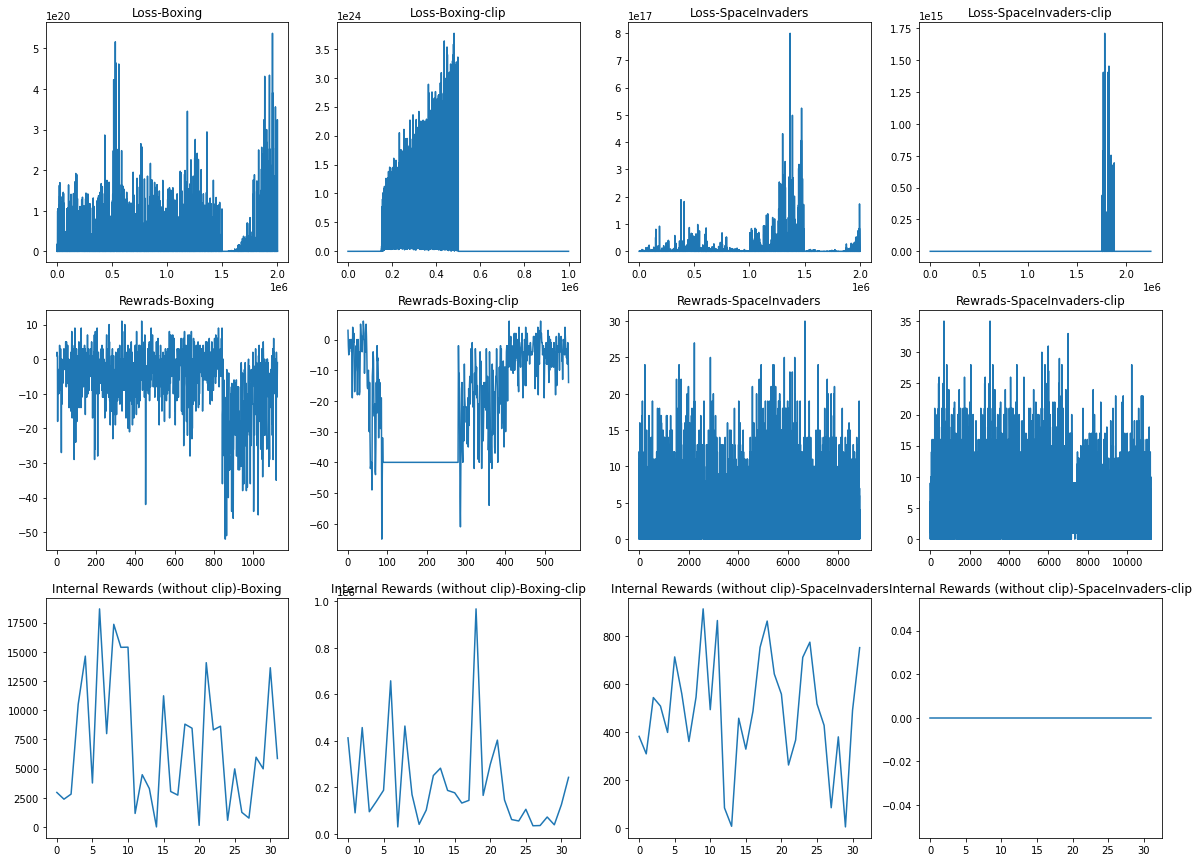

In [13]:
lst = ['Boxing','Boxing-clip','SpaceInvaders','SpaceInvaders-clip']
fig, axs = plt.subplots(3, 4, figsize=(20,15))

for i in range(0,len(lst)):
  print(lst[i])
  rewards = []
  loss = []
  intrinsic_rewards = []
  for j in os.listdir(checkpoint_name+lst[i]+'/'):
    with open(checkpoint_name+lst[i]+'/'+j,'rb') as f:
      data = pkl.load(f)
      loss = loss + data['loss']
      rewards = rewards + data['reward']
      intrinsic_rewards = intrinsic_rewards + data['intrinsic_rewards']
  axs[0,i].plot(loss)
  axs[0,i].title.set_text('Loss-'+lst[i])
  axs[1,i].plot(rewards)
  axs[1,i].title.set_text('Rewrads-'+lst[i])
  axs[2,i].plot(intrinsic_rewards[10000].cpu().numpy()[:])
  axs[2,i].title.set_text('Internal Rewards (without clip)-'+lst[i])

plt.show()


# for j in lst:
#     with open(checkpoint_name+'/'+j+'.pkl', 'rb') as f: #data+same as frame folder
#         data = pkl.load(f)
#         loss = loss + data['loss']
#         Rewards = Rewards + data['reward']

# plt.figure()
# plt.title('Loss')
# plt.plot(losses)
# plt.show()

# plt.figure()
# plt.title('Rewards')
# plt.plot(all_rewards)
# plt.show()

# plt.figure()
# plt.title('Internal Rewards')
# plt.plot(internal_rewards[10000].cpu().numpy()[:])
# plt.show()